In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="1"; 

import urllib.request
import pandas as pd
import numpy as np

In [2]:
import ktrain
from ktrain import tabular

# Income Prediction from Census Dataset

In this notebook, we will predict which individuals make more than $50K from Census data.  This is the same dataset used in the [AutoGluon tabular prediction example](https://autogluon.mxnet.io/tutorials/tabular_prediction/tabular-quickstart.html).

## Collect Training and Test Sets

The original dataset is available from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Adult), but we will download it from the AutoGluon website.

In [3]:
# training set
urllib.request.urlretrieve('https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv', 
                           '/tmp/train.csv')

('/tmp/train.csv', <http.client.HTTPMessage at 0x7fab9bfeeb38>)

## STEP 1:  Load and Preprocess Data

In [4]:
trn, val, preproc = tabular.tabular_from_csv('/tmp/train.csv', label_columns='class', random_state=42)

processing train: 35179 rows x 15 columns

The following integer column(s) are being treated as categorical variables:
['education-num']
To treat any of these column(s) as numerical, cast the column to float in DataFrame or CSV
 and re-run tabular_from* function.

processing test: 3894 rows x 15 columns


## STEP 2: Create Model and Wrap in `Learner`

In [5]:
model = tabular.tabular_classifier('mlp', trn)
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=128)

Is Multi-Label? False
done.


## STEP 3: Estimate LR

This step is optional, as an learning rate of `1e-3` tends to work well for MLPs using Adam optimizer.

simulating training for different learning rates... this may take a few moments...
Train for 274 steps
Epoch 1/1024
274/274 [==============================] - 9s 32ms/step - loss: 1.4122 - accuracy: 0.4891
Epoch 2/1024
274/274 [==============================] - 7s 26ms/step - loss: 1.1026 - accuracy: 0.5617
Epoch 3/1024
274/274 [==============================] - 7s 26ms/step - loss: 0.7489 - accuracy: 0.6993
Epoch 4/1024
274/274 [==============================] - 7s 26ms/step - loss: 0.4926 - accuracy: 0.7927
Epoch 5/1024
274/274 [==============================] - 7s 26ms/step - loss: 0.4247 - accuracy: 0.8122
Epoch 6/1024
108/274 [==========>...................] - ETA: 4s - loss: 0.9780 - accuracy: 0.7877

done.
Visually inspect loss plot and select learning rate associated with falling loss


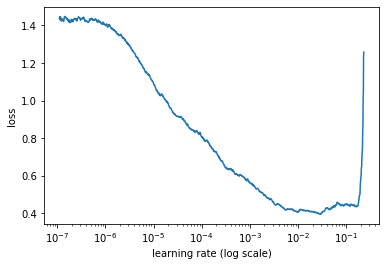

In [8]:
learner.lr_find(show_plot=True)

## STEP 4: Train

In [6]:
learner.autofit(1e-3)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train for 275 steps, validate for 122 steps
Epoch 1/1024
275/275 [==============================] - 11s 40ms/step - loss: 0.5886 - accuracy: 0.7620 - val_loss: 0.4721 - val_accuracy: 0.7879
Epoch 2/1024
275/275 [==============================] - 10s 35ms/step - loss: 0.4022 - accuracy: 0.8190 - val_loss: 0.3614 - val_accuracy: 0.8539
Epoch 3/1024
275/275 [==============================] - 10s 35ms/step - loss: 0.3674 - accuracy: 0.8309 - val_loss: 0.3279 - val_accuracy: 0.8421
Epoch 4/1024
275/275 [==============================] - 10s 35ms/step - loss: 0.3551 - accuracy: 0.8357 - val_loss: 0.3208 - val_accuracy: 0.8531
Epoch 5/1024
275/275 [==============================] - 10s 35ms/step - loss: 0.3505 - accuracy: 0.8376 - val_loss: 0.3178 - val_accuracy: 0.8511
Epoch 6/1024
275/275 [====================

In [7]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

       <=50K       0.90      0.92      0.91      3013
        >50K       0.70      0.65      0.68       881

    accuracy                           0.86      3894
   macro avg       0.80      0.78      0.79      3894
weighted avg       0.86      0.86      0.86      3894



array([[2774,  239],
       [ 310,  571]])

## Evaluate Model on Unseen Test Data

In [8]:
# download test dataset
urllib.request.urlretrieve('https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv', 
                           '/tmp/test.csv')


test_df = pd.read_csv('/tmp/test.csv')

In [9]:
test_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,31,Private,169085,11th,7,Married-civ-spouse,Sales,Wife,White,Female,0,0,20,United-States,<=50K
1,17,Self-emp-not-inc,226203,12th,8,Never-married,Sales,Own-child,White,Male,0,0,45,United-States,<=50K
2,47,Private,54260,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1887,60,United-States,>50K
3,21,Private,176262,Some-college,10,Never-married,Exec-managerial,Own-child,White,Female,0,0,30,United-States,<=50K
4,17,Private,241185,12th,8,Never-married,Prof-specialty,Own-child,White,Male,0,0,20,United-States,<=50K


The `learner.evaluate` method is just an alias to `learner.validate`.  By default, it was validate/evaluate
`learner.val_data`, but both can accept a test set as an argument in the form of a `TabularDataset`.

We use `learner.evaluate` here to compute test set metrics.

In [13]:
learner.evaluate(preproc.preprocess_test(test_df), class_names=preproc.get_classes())

processing test: 9769 rows x 15 columns
              precision    recall  f1-score   support

       <=50K       0.89      0.92      0.90      7451
        >50K       0.71      0.65      0.68      2318

    accuracy                           0.85      9769
   macro avg       0.80      0.78      0.79      9769
weighted avg       0.85      0.85      0.85      9769



array([[6827,  624],
       [ 819, 1499]])

#### Generating Test Results

Let's generate a DataFrame showing the test set predictions for each instance:

In [14]:
preproc.get_classes()

['<=50K', '>50K']

In [18]:
predictor = ktrain.get_predictor(learner.model, preproc)
preds = predictor.predict(test_df)

In [19]:
df = test_df.copy()

In [20]:
df['predicted_class'] = preds

In [21]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,predicted_class
0,31,Private,169085,11th,7,Married-civ-spouse,Sales,Wife,White,Female,0,0,20,United-States,<=50K,<=50K
1,17,Self-emp-not-inc,226203,12th,8,Never-married,Sales,Own-child,White,Male,0,0,45,United-States,<=50K,<=50K
2,47,Private,54260,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1887,60,United-States,>50K,>50K
3,21,Private,176262,Some-college,10,Never-married,Exec-managerial,Own-child,White,Female,0,0,30,United-States,<=50K,<=50K
4,17,Private,241185,12th,8,Never-married,Prof-specialty,Own-child,White,Male,0,0,20,United-States,<=50K,<=50K
